<a href="https://colab.research.google.com/github/jose-cano/Deep-Learning/blob/main/Primate_Classifier.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Primate Classifier

In this notebook, we'll build an image classifier using fastai. Fastai is a deep learning library built on top of PyTorch that provides additional tools to quickly build state-of-the-art models for common deep learning domains.

We'll build a model that can classify primates into categories: Orangutan, Chimpanzee, or Gorilla. You could imagine such a model being used by zoologists that monitor the habitats of these animals.

The basic steps we'll take are:

1. Use DuckDuckGo to search for images of these primates.
2. Fine-tune a pretrained neural network to recognise these two groups
3. Try running this model on a picture of a primate and see if it works.

In [ ]:
import shutil
import os

def delete_folder(folder_path):
    # Verify if the folder exists
    if os.path.exists(folder_path):
        # Delete the folder and its contents recursively
        shutil.rmtree(folder_path)
        print(f"Folder '{folder_path}' and its contents have been deleted.")
    else:
        print(f"Folder '{folder_path}' does not exist.")


# folder_path = '/content/primates'
# delete_folder(folder_path)

In [ ]:
!pip install -Uqq fastai duckduckgo_search

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 75.4/75.4 kB 883.0 kB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.6/62.6 kB 3.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 72.5/72.5 kB 2.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 57.5/57.5 kB 3.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.3/58.3 kB 4.1 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
google-colab 1.0.0 requires requests==2.27.1, but you have requests 2.31.0 which is incompatible.


# 1. Downloading images

In [ ]:
from duckduckgo_search import ddg_images
from fastcore.all import *

def search_images(term, max_images=100):
    print(f"Searching for '{term}'")
    return L(ddg_images(term, max_results=max_images)).itemgot('image')

In [ ]:
#NB: `search_images` depends on duckduckgo.com, which doesn't always return correct responses.
#    If you get a JSON error, just try running it again (it may take a couple of tries).
urls = search_images('orangutan photos', max_images=1)
urls[0]

Searching for 'orangutan photos'


'https://3.bp.blogspot.com/-U-VHGwss-7w/T5gG3rXizJI/AAAAAAAAFXU/-hfud4KsU4s/s1600/baby_orangutan.jpg'

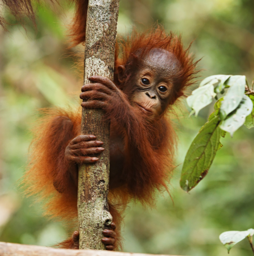

In [ ]:
from fastdownload import download_url
dest = 'orangutan.jpg'
download_url(urls[0], dest, show_progress=False)

from fastai.vision.all import *
im = Image.open(dest)
im.to_thumb(256,256)

Searching for 'gorilla photos'


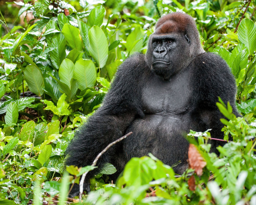

In [ ]:
download_url(search_images('gorilla photos', max_images=1)[0], 'gorilla.jpg', show_progress=False)
Image.open('gorilla.jpg').to_thumb(256,256)

Searching for 'chimpanzee photos'


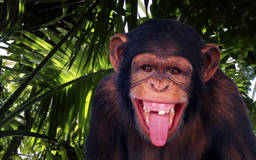

In [ ]:
download_url(search_images('chimpanzee photos', max_images=1)[0], 'chimpanzee.jpg', show_progress=False)
Image.open('chimpanzee.jpg').to_thumb(256,256)

Our searches seem to be giving reasonable results, so let's grab a few examples of each primate photo, and save each group of photos to a different folder (I'm also trying to grab a range of conditions here):

In [ ]:
searches = 'orangutan','gorilla', 'chimpanzee'
path = Path('primates')
from time import sleep

for o in searches:
    dest = (path/o)
    dest.mkdir(exist_ok=True, parents=True)
    download_images(dest, urls=search_images(f'{o} photo'))
    sleep(5)  # Pause between searches to avoid over-loading server
    download_images(dest, urls=search_images(f'{o} playing photo'))
    sleep(5)
    download_images(dest, urls=search_images(f'{o} eating photo'))
    sleep(5)
    resize_images(path/o, max_size=400, dest=path/o)

Searching for 'orangutan photo'


/usr/local/lib/python3.10/dist-packages/duckduckgo_search/compat.py:60: UserWarning: ddg_images is deprecated. Use DDGS().images() generator
  warnings.warn("ddg_images is deprecated. Use DDGS().images() generator")
/usr/local/lib/python3.10/dist-packages/duckduckgo_search/compat.py:64: UserWarning: parameter page is deprecated
  warnings.warn("parameter page is deprecated")
/usr/local/lib/python3.10/dist-packages/duckduckgo_search/compat.py:66: UserWarning: parameter max_results is deprecated
  warnings.warn("parameter max_results is deprecated")


Searching for 'orangutan playing photo'
Searching for 'orangutan eating photo'
Searching for 'gorilla photo'
Searching for 'gorilla playing photo'
Searching for 'gorilla eating photo'
Searching for 'chimpanzee photo'
Searching for 'chimpanzee playing photo'
Searching for 'chimpanzee eating photo'


# 2. Train Model

Some photos might not download correctly which could cause our model training to fail, so we'll remove them:

In [ ]:
failed = verify_images(get_image_files(path))
failed.map(Path.unlink)
len(failed)

22

Next, we'll use another building block from the fastai library, the DataBlock class, which we can use to represent our training data, the labels, data splitting criteria, and any data transformations.

blocks=(ImageBlock, CategoryBlock) is used to specify what kind of data is in the DataBlock. We have images, and categories - hence a tuple of ImageBlock and CategoryBlock classes.

get_items takes the function get_image_files as its parameter. get_image_files is used to find the paths of our input images.

splitter=RandomSplitter(valid_pct=0.2, seed=42) specifies that we want to randomly split our input data into training and validation sets, using 20% data for validation.

get_y=parent_label specifies that the labels for an image file is its parent (the directory that the file belongs to).

item_tfms=[Resize(192, method='squish')] specifies the transformation performed on each file. Here we are resizing each image to 192x192 pixels by squishing it. Another option could be to crop the image.

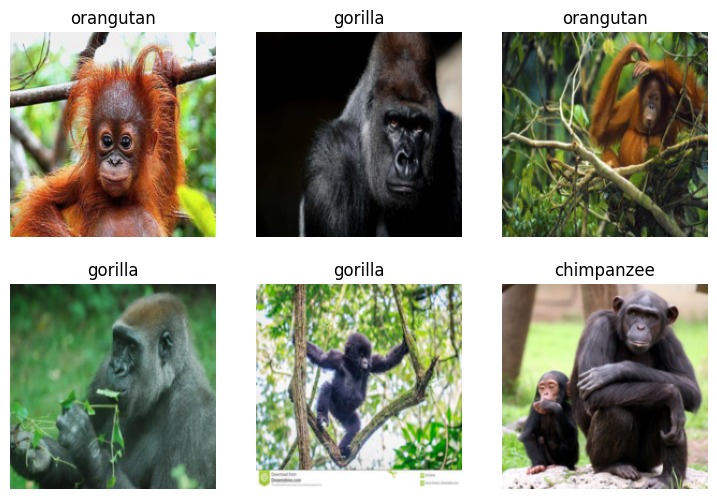

In [ ]:
dls = DataBlock(
    blocks=(ImageBlock, CategoryBlock), 
    get_items=get_image_files, 
    splitter=RandomSplitter(valid_pct=0.2, seed=42),
    get_y=parent_label,
    item_tfms=[Resize(192, method='squish')]
).dataloaders(path, bs=32)

dls.show_batch(max_n=6)

Now we're ready to train our model. The fastest widely used computer vision model is resnet18. You can train this in a few minutes, even on a CPU. (On a GPU, it generally takes under 10 seconds...)

fastai comes with a helpful fine_tune() method which automatically uses best practices for fine tuning a pre-trained model, so we'll use that.

In [ ]:
learn = vision_learner(dls, resnet18, metrics=error_rate)
learn.fine_tune(4)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 118MB/s]


epoch,train_loss,valid_loss,error_rate,time
0,0.979049,0.159286,0.046358,00:11


epoch,train_loss,valid_loss,error_rate,time
0,0.248363,0.182262,0.052980,00:04
1,0.161228,0.136485,0.039735,00:04
2,0.100991,0.124657,0.033113,00:05
3,0.067721,0.111025,0.033113,00:04


# Step 3: Use our model

Let's see what our model thinks about an unseen primate example!

Searching for 'orangutan climbing'


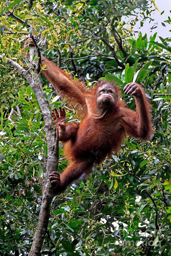

In [ ]:
download_url(search_images('orangutan climbing', max_images=1)[0], 'orangutan_climbing.jpg', show_progress=False)
Image.open('orangutan_climbing.jpg').to_thumb(256,256)

In [ ]:
primate_cat,idx,probs = learn.predict(PILImage.create('orangutan_climbing.jpg'))
print(f"This is a: {primate_cat}.")
print(f"Probability it's an orangutan: {probs[idx.item()]:.4f}")

This is a: orangutan.
Probability it's an orangutan: 1.0000


Searching for 'gorilla standing'


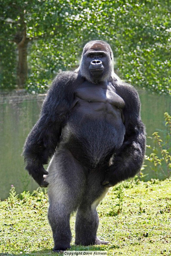

In [ ]:
download_url(search_images('gorilla standing', max_images=1)[0], 'gorilla_standing.jpg', show_progress=False)
Image.open('gorilla_standing.jpg').to_thumb(256,256)

In [ ]:
primate_cat,idx,probs = learn.predict(PILImage.create('gorilla_standing.jpg'))
print(f"This is a: {primate_cat}.")
print(f"Probability it's a gorilla: {probs[idx.item()]:.4f}")

This is a: gorilla.
Probability it's a gorilla: 0.9987


Searching for 'chimpanzee baby'


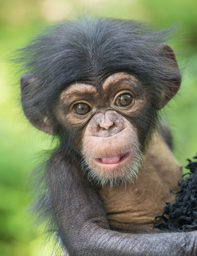

In [ ]:
download_url(search_images('chimpanzee baby', max_images=1)[0], 'chimpanzee_baby.jpg', show_progress=False)
Image.open('chimpanzee_baby.jpg').to_thumb(256,256)

In [ ]:
primate_cat,idx,probs = learn.predict(PILImage.create('chimpanzee_baby.jpg'))
print(f"This is a: {primate_cat}.")
print(f"Probability it's a chimpanzee: {probs[idx.item()]:.4f}")

This is a: chimpanzee.
Probability it's a chimpanzee: 0.9980


In [ ]:
learning_interpreter = ClassificationInterpretation.from_learner(learn)

By looking at the confusion matrix below, it seems the model performed very well across all categories. It only missclassified 5 samples from the validation set.

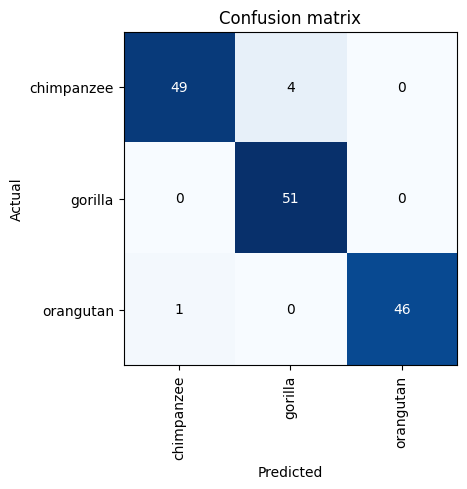

In [ ]:
learning_interpreter.plot_confusion_matrix()

Our model mostly confuses chimpanzees as gorillas, which isnt surprising as these two are more similar to each other than they are to orangutans.

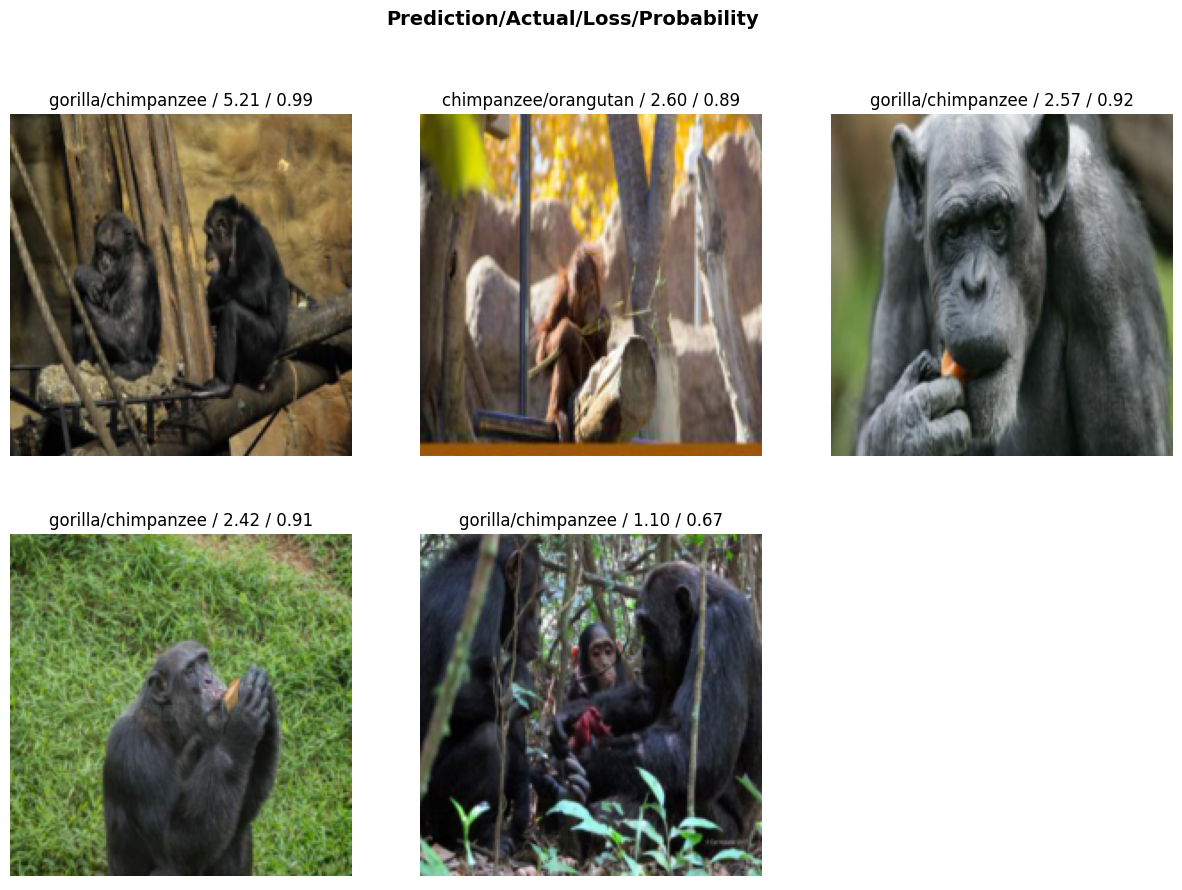

In [ ]:
learning_interpreter.plot_top_losses(5, figsize=(15,10))

# Conclusions

With a few lines of code we have created our own image classification model by fine-tuning ResNet18 using fastai. The high level apis that the library provides makes the process of building performant models and evaluating them very easy. As I study this library, it will become more apparent what other advantages it provides.